In [5]:
%load_ext autoreload
%autoreload 2
from importlib import reload

from collections import defaultdict

import numpy

import random
from matplotlib import pyplot as plt
from random import shuffle, choice, randint

import math
import keras
import tensorflow

from NN_utils import BigTable, WeightClip

import pickle
import zlib

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/(comps))
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

print("started")


from sklearn.svm import SVR


def calc_probs_from_embs(students,questions):
    students2 = numpy.repeat(students, len(questions), axis=0)
    questions2 = numpy.tile(questions, (len(students),1))
    zmask = numpy.isclose(questions2,-10).astype(int)
    diffs = students2-questions2
    prs = 1.0/(1.0+ numpy.exp(-diffs))
    prs = numpy.maximum(zmask,prs)
    probs2 = numpy.prod(prs, axis=1).reshape(len(students), len(questions))
    return probs2


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


started


In [6]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits):
    students = numpy.zeros((n_students, n_factors))
    for six in range(n_students):
#         true_comps = numpy.random.normal(a0, a1, size=n_factors)#+0.2#+2#+1.2
#         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
        true_comps = numpy.random.uniform(0,1, size=n_factors)#+0.2#+2#+1.2
        for cix,c in zip(range(n_factors), true_comps):
            students[six,cix] = c

    questions = numpy.zeros((n_questions, n_factors))
    for qix in range(n_questions):
#         n_comps = randint(min_active_traits, max_active_traits)
        n_comps = n_factors
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)
        true_comps = numpy.random.uniform(a0[0],a0[1], size=n_comps)

        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c#+boost
    
    print("genqs",students.shape, questions.shape)
    return students, questions

def gen_bayes_run(n_traits, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits)
    print(students.shape, questions.shape)
    obs = numpy.zeros((len(students), len(questions)))
    probs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    for vi in range(len(students)):
        for mi in range(len(questions)):
            prs = (1-questions[mi]) + (questions[mi]*students[vi])
            pr = numpy.prod(prs)
            obs[vi,mi] = (random.random() < pr)
            probs[vi,mi] = pr
    return obs, probs, students, questions

# n_students, n_questions, n_factors, min_active, max_active = 100,100,10,10,10

In [7]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits, test_w):
    students = numpy.zeros((n_students, n_factors))
#     for six in range(n_students):
#         true_comps = numpy.random.normal(0, a1, size=n_factors)#+0.2#+2#+1.2
# #         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
# #         true_comps = numpy.random.uniform(0,1, size=n_factors)#+0.2#+2#+1.2
#         for cix,c in zip(range(n_factors), true_comps):
#             students[six,cix] = c

    students = numpy.random.normal(0, a1, size=(n_students,n_factors))
            
    av_c = (min_active_traits + max_active_traits)/2
    d50 = pr_to_spread(.5, av_c, as_A_and_D=False)
    
    questions = numpy.zeros((n_questions, n_factors)) - 10
    
    minb=-(test_w/2) -a0 - d50
    maxb=(test_w/2) -a0 - d50
    questions = questions
    minb, maxb = sorted([minb, maxb])
    minb = float(minb)
    maxb = float(maxb)
    
    for qix in range(n_questions):
        n_comps = randint(min_active_traits, max_active_traits)
#         print("n_comps", n_comps)
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)  
#         print("range=", minb,maxb)
        true_comps = numpy.random.uniform(minb, maxb, size=n_comps)
        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c
            
    return students, questions

def gen_rasch_run(n_factors, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits, test_w=test_w)
    obs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    
#     students2 = numpy.repeat(students, n_questions, axis=0)
#     questions2 = numpy.tile(questions, (n_students,1))
    
# #     print("st and qn shapes:")
# #     print(students.shape)
# #     print(questions.shape)
    
#     zmask = numpy.isclose(questions2,-10).astype(int)
# #     print("zmask shape:", zmask.shape)
#     diffs = students2-questions2
# #     print("diffs shape:", diffs.shape)
#     prs = 1.0/(1.0+ numpy.exp(-diffs))
#     prs = numpy.maximum(zmask,prs)
#     probs2 = numpy.prod(prs, axis=1).reshape(n_students, n_questions)
        
#     probs2 = calc_probs_from_embs(students, questions)
    probs2 = None
    
#     for vi in range(len(students)):
#         for mi in range(len(questions)):
#             zmask = numpy.isclose(questions[mi],-10).astype(int)
#             diffs = students[vi]-questions[mi]
#             prs = logistic(diffs,1,0)
#             prs = numpy.maximum(zmask,prs)

#             pr = numpy.prod(prs)
#             obs[vi,mi] = (random.random() < pr)
#             probs[vi,mi] = pr
            
    return obs, probs2, students, questions



In [8]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Dense
from keras import backend as K, Model
from keras.optimizers import Adam
def generate_offset_generator(w=5,d=4):
    #width, dispersal, target_EV
    h=None
    inp = Input(shape=(3,))
    for _ in range(d):
        if h==None:
            h = Dense(w, activation="relu")(inp)
        else:
            h = Dense(w, activation="relu")(h)
    last_layer=inp if (h is None) else h
    offset = Dense(1, activation="linear")(last_layer)
    model = Model(inputs=[inp], outputs=[offset])
    model.compile(optimizer=Adam(), loss="mse")
    print(model.summary())
    return model

In [9]:
# a1 = 5/3
# a0 = 1.75
# tw = 3.5
from sklearn.metrics import mean_squared_error

from keras.callbacks import EarlyStopping
def create_offset_generator(n_factors, min_active, max_active, sampsize=14, n_iter=20000, rasch=True):
    n_questions = int(sampsize / 0.9)
    n_students = int(sampsize / 0.9)
    inps = []
    outs = []

    i=0
#     for a in range(n_iter):
    print("generating generator training mini-datasets...")
    n_dropped = 0
    while i < n_iter:

#         tw = random.uniform(0, 5)
#         a0 = random.uniform(-4, 5)
#         a1 = random.uniform(.5, 4)

        tw = random.uniform(0, 5)
        a0 = random.uniform(-5, 5)
        a1 = random.uniform(0, 4)

#         tw = random.uniform(0, 10)
#         a0 = random.uniform(-10, 10)
#         a1 = random.uniform(0, 10)


#         print(tw,a1,"...",a0)
        
        if rasch:
            _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)
        else:
            _, _, students_temp, qz_temp  = gen_bayes_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)

        students2 = students_temp
        questions = qz_temp


        obs = (random.random() < probs).astype(int)
        exp_ob = numpy.mean(probs.flatten())
        if exp_ob <= 0.1 or exp_ob >= 0.9:
            n_dropped +=1
            continue
        i+=1
            
#         hard =numpy.round(probs)
#         plt.hist(hard.flatten())
#         plt.show()

#         agt = 0 #numpy.zeros_like(probs)
#         n_agt_runs = 20
#         for _ in range(n_agt_runs):
#             this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
# #             plt.hist(this_obs.flatten())
# #             plt.show()
#             this_agt = numpy.mean(((hard==this_obs).astype(float)).flatten())
# #             this_agt= numpy.std(probs.flatten() -0.5 )
# #             print("Agt:", this_agt)
#             agt += this_agt 
#         agt /= n_agt_runs
        
#         plt.hist(probs.flatten())
#         plt.show()
#         print("tw, a1, a0", tw, a1, a0)
#         print("Mean agt:", agt)
#         print("Exp pr:", exp_ob)
        
        
        print(i, exp_ob)
        inps.append([tw,a1, exp_ob])
        outs.append(a0)
#         for p in probs.flatten():
#             inps.append([tw,a1, p])
#             outs.append(a0)
        
    print("done!")

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    
    split = len(inps)//10
    vinps = numpy.array(inps[split:])
    vouts = numpy.array(outs[split:])
    inps = numpy.array(inps[:split])
    outs = numpy.array(outs[:split])
    print(inps.shape, outs.shape)

    best_mse = math.inf
    best = None
    best_dims = None
#     seen = set()
                        
    for nnw in [16]: # [2,4,8,16,32]:
        for nnd in [2]: #[0,1,2,3,5]:
#             if (nnw,nnd) in seen:
#                 continue
#             seen.add((nnw,nnd))
            gen_m = generate_offset_generator(nnw, nnd)
            h = gen_m.fit(inps,outs, epochs=10000, shuffle=True, batch_size=len(inps), callbacks=[es], validation_split=0.1, verbose=1)
            
#             gen_m = SVR()
#             gen_m.fit(inps, outs)
            
            mse = mean_squared_error(vouts,gen_m.predict(vinps))
            if mse < best_mse:
                print("new best:",nnw,nnd,":",mse)
                best_mse = mse
                best_dims = (nnw,nnd)
                best = gen_m
    
    predz = best.predict(inps)
#     for i,p,o in zip(inps,predz, outs):
#         print(i, p, o)
    print("Best generator for", (n_factors, min_active, max_active), "is", best_dims)
    print("avg", numpy.mean(outs), "vs", numpy.mean(predz))
    print("number of extreme cases = ", n_dropped, "as prop of ",n_iter," iters", n_dropped/n_iter)
    print(mean_squared_error(vouts, best.predict(vinps)))
    
    h=None
    return best, h, best_dims, best_mse

In [10]:
def calc_arr_arr_err(split, real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    print(split, real_wgts.shape, pred_wgts.shape, max_iter)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None
    curr_real_ix = None
    
    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    pred_col = pred_col #* pred_q_col
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    
                    if err < curr_err:
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = 0#cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = numpy.array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        
        dis = 0
        mean_ll = numpy.mean( out_col_arr - real_wgts )
        if total_err < min_total_err:
            min_total_err = total_err
            total_q_err = numpy.mean(numpy.abs( out_col_arr[0:split] - real_wgts[0:split] ))
            total_s_err = numpy.mean(numpy.abs( out_col_arr[split:] - real_wgts[split:] ))
            best_ll = mean_ll
            chosen = out_col_arr
            best_dis = dis
    return chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_dis


In [11]:
import copy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def plot_items(pred_list, real_items, s_offset):
    if real_items.shape[1]<2:
        print("real_items is only 1 component wide .. needs to be >1 to plot on a PCA graph")
        return None
    elif real_items.shape[1]==2:
        print("2 comps, so no dim reduc")
        tx=None
    else:
        tx = PCA(n_components=2)
#         tx = TSNE(n_components=2)
    fyrst = True
    Cs = []
    C_labs = []
    pred_list = numpy.array(pred_list)
    print("pred list shape", pred_list.shape)
    print("real items shape", real_items.shape)


    fitted_pred_list = []
#     offset = numpy.median(pred_list[(pred_list>0.1)], axis=0) - numpy.median(real_items[(real_items>0.1)], axis=0)
#     real_mean = numpy.min(real_items[real_items > 0.1])
#     offset = numpy.min(pred_list[pred_list > 0.1]) - real_mean
#     print("real mean", real_mean)
#     print("offset", offset)
    
    m = len(real_items)
    cols = list(range(m))
    shuffle(cols)
    
    xmeans = numpy.zeros(m)
    ymeans = numpy.zeros(m)
    pairs = defaultdict(list)
    iter = 0
    
    cp_real = copy.copy(real_items)
    cp_real[cp_real < 1] = numpy.nan
    r_offset=numpy.nanmedian(cp_real, axis=0)
    
    itemz_2 = real_items
    n = len(real_items)
    
    for opreds in pred_list:
        preds = copy.copy(opreds) #- s_offset[iter] + r_offset
        split = 0
        
        items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_items, preds, max_iter=10)

        itemz_pred = items_chosen
        print(itemz_pred)
#         itemz_pred = numpy.maximum(itemz_pred,0)
        fitted_pred_list.append(itemz_pred)
        
#         itemz = real_items #- offset
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         itemz = numpy.maximum(itemz,0)
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         if itemz_2 is None:
#             itemz_2 = numpy.concatenate([real_itemz, itemz_pred], axis=0)
#         else:
        itemz_2 = numpy.concatenate([itemz_2, itemz_pred], axis=0)

    if tx:
        itemz_2 = tx.fit_transform(itemz_2)
#         itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
#         if fyrst:
#         itemz_2 = tx.fit_transform(itemz_2)
#             fyrst = False
#         else:
#             itemz_2 = tx.transform(itemz_2)

    from sklearn.cluster import KMeans
    iter=0
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    
    for opreds, itemz_pred in zip(pred_list, fitted_pred_list):
        n = len(itemz_pred)
        km = KMeans()
        km.fit(itemz_pred)
        cluster_labels = km.predict(itemz_pred)
        print(cluster_labels)
        
        C = []
        for l in set(cluster_labels):
            cluster = list(numpy.where(cluster_labels==l)[0])
            print("X", cluster)
            C.append(cluster)
        Cs.append(C)
        C_labs.append(cluster_labels)
                
#         NUM_COLORS = 100
#         cm = plt.get_cmap('gist_rainbow')
#         fig.gca().set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        print(type(itemz_2))
        minix=n*(iter+1)
        maxix=n*(iter+1)+n
        
        #i=0 -> 100,199
        #i=2 -> 200,299
        
        print("no pts=",n," indices=", minix, maxix)
        print("shape of itemz_2", itemz_2.shape)
        fig.gca().scatter(itemz_2[minix:maxix,0], itemz_2[minix:maxix,1], alpha=0.7, c=numpy.array(cols), cmap=plt.get_cmap('nipy_spectral'))
        j=0
        for j in range(n):
            x,xh,y,yh = itemz_2[j+(n*iter),0], itemz_2[j+(n*iter+n) ,0], itemz_2[j+(n*iter),1], itemz_2[j+(n*iter+n),1]
#             fig.gca().plot([x,xh],[y,yh],  color="#aaaaaa80")
            xmeans[j] += xh
            ymeans[j] += yh
            pairs[iter].append((xh, yh))
        iter+=1
        
    for j in range(n):
        fig.gca().annotate(j, (itemz_2[j,0], itemz_2[j,1]))
        
    fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], c="b", zorder=10, alpha=0.5)
#     fig.gca().axhline(y=1e-6, linestyle="--")
#     fig.gca().axvline(x=1e-6, linestyle="--")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    
    xmeans = xmeans / len(pred_list)
    ymeans = ymeans / len(pred_list)
    

    if len(pred_list)>=1:
        for it in range(len(pred_list)):
            xhyh_pairs = pairs[it]
            for j,hat_pair in enumerate(xhyh_pairs):
                xh,yh = hat_pair
                x,y = itemz_2[j,0], itemz_2[j,1]
                mux = xmeans[j]
                muy = ymeans[j]
#                 fig.gca().scatter(xh, yh, alpha=0.7, c=plt.get_cmap('nipy_spectral')(cols[j]))
#                 fig.gca().scatter(mux,muy, c="#888888ff", marker="*", zorder=10)
#                 fig.gca().plot([mux,xh],[muy,yh],color="#aaaaaa80", linestyle="--")
#                 fig.gca().plot([mux,x],[muy,y],color="#888888dd", linestyle="-")
                fig.gca().plot([x,xh],[y,yh],color="#aaaaaa80", linestyle="--")
        
    plt.show()
    print("len Cs", len(Cs))
    from sklearn.metrics.cluster import adjusted_rand_score
    rands = []
    for ix in range(len(Cs)):
#         print(ix)
        for jx in range(len(Cs)):
#             print(jx)
            if ix!=jx:
#             print(Cs[ix], Cs[jx])
#                 print("VI:", ix,jx, varinfo(Cs[ix],Cs[jx]))
                a_rand = adjusted_rand_score(C_labs[ix], C_labs[jx])
                print("Rand:", a_rand)
                rands.append(a_rand)
    print("Mean rand score =", numpy.mean(rands), numpy.std(rands))

# qws = qn_table.get_weights()[0]
# qws2 = qn_table2.get_weights()[0]

In [56]:
def calc_probs(s,q):
    zmask = numpy.isclose(q,-10).astype(int)
    diff = s-q
    prs = 1.0/(1.0+ numpy.exp(-diff))
    prs = numpy.maximum(zmask,prs)
    pr = numpy.prod(prs, axis=-1).reshape(len(q))
    return pr
    
def stitch_n_split(_pairs, sts, qns, realise=True, rpt=False):
    out_w = 50
    max_fails = out_w -1
    if realise:
        if rpt:
            _counts = defaultdict(int)
            _matches=[]
            _pfz=[]
            _sz, _qz = [],[]
            cache = defaultdict(list)
            for (vi,mi) in _pairs:
                cache[vi].append(mi)
            
            for vi in cache:
                s = sts[vi]
                prs = calc_probs(s, [qns[k] for k in cache[vi]])  
#                 print("shape of prs", prs.shape)
                for mix,mi in enumerate(cache[vi]):
#                 pr = _probs[vi,mi]
                    pr = prs[mix]
                    rnd = random.random()
                    i=0
                    while rnd > pr and i<max_fails:
                        i += 1
                        rnd = random.random()

                    zs = numpy.zeros(max_fails+1)
                    zs[i] = 1
                    _counts[i] += 1

                    _pfz.append(zs)
    #                 _pfz.append(i)
                    _sz.append(vi)
                    _qz.append(mi)
            print("probs calced")
        else:
            _prob_list =  numpy.array([calc_prob(sts[vi],qns[mi]) for (vi,mi) in _pairs])
            _pfz = (numpy.random.random(len(_prob_list)) < _prob_list).astype(int)
    #     _pfz = (0.5 < _prob_list).astype(int)
            _matches = ( numpy.round(_prob_list) == _pfz).astype(int)
        print("realisation complete")
    else:
        _prob_list =  numpy.array([calc_prob(sts[vi],qns[mi]) for (vi,mi) in _pairs])
        _pfz = _prob_list
        _matches = numpy.ones_like(_prob_list)
        _sz = [p[0] for p in _pairs]
        _qz = [p[1] for p in _pairs]

#     print(_pfz)
#     _pfz = numpy.array([probs[vi,mi] for (vi,mi) in _pairs])

#     print(_matches)
#     print(numpy.sum(_matches), "correctly labelled out of", len(_matches), "%=", numpy.sum(_matches)/len(_matches))
    if not rpt:
        _sz = [p[0] for p in _pairs]
        _qz = [p[1] for p in _pairs]
    print("sns complete")
    
    one_c = _counts[1]
    for k in _counts:
        c = _counts[k]
        _counts[k] = one_c / c
    
    return numpy.array(_pfz), _sz, _qz, _counts

c [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
1 0.03 0.03
c [1 1 0 2 0 1 1 1 1 1 0 0 2 1 1 2 0 0 1 0 0 0 1 2 1 0 1 0 1 0 1 1 1 0 0 0 1
 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 2 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1
 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 2 1 0 0]
17 0.43 0.49
c [1 2 0 4 1 4 2 2 2 1 1 1 2 1 1 3 1 0 2 0 0 0 2 2 2 0 1 0 1 0 2 2 1 0 0 2 2
 1 2 0 2 2 0 1 1 1 2 3 0 1 0 1 0 0 0 1 2 1 2 0 0 0 0 2 0 0 0 1 0 0 0 1 2 1
 0 0 2 1 2 2 1 1 1 1 3 1 1 1 0 0 2 0 1 0 1 0 2 3 1 0]
34 0.65 1.05
c [1 3 0 4 2 4 3 5 2 1 4 1 2 2 1 3 2 1 2 0 0 1 2 2 2 0 1 0 1 0 2 2 1 0 0 2 2
 1 2 0 2 2 0 2 1 3 2 3 0 3 0 1 1 1 0 1 2 2 2 0 0 1 0 3 1 0 0 1 1 2 0 1 2 3
 2 0 3 1 2 3 1 1 1 2 3 1 1 3 2 1 3 0 1 3 1 1 2 4 1 1]
50 0.79 1.51
c [1 3 1 4 2 4 3 5 3 1 5 1 2 3 1 3 2 1 3 1 1 1 2 2 4 0 2 0 1 1 2 2 2 1 0 3 2
 1 2 0 2 3 1 2 1 4 2 3 1 3 0 2 1 2 0 1 2 3 2 0 0

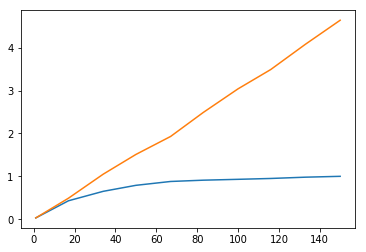

In [13]:
def calc_skills_coverage():
    xs=[]
    ys=[]
    ycnts=[]
    n_factors, min_active, max_active = 100,1,5
    n_students = 1
    tw=1
    a0=1
    a1=1
    max_n_qns = 150
    n_questions_list = numpy.linspace(1,max_n_qns,num=10).astype("int")

    _, _, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=max_n_qns)
    for n_questions in n_questions_list:
        cnt = numpy.array([False]*n_factors).astype("int")
#         plt.hist(qz_temp.flatten(), alpha=0.5)
#         plt.show()
        for q in qz_temp[0:n_questions]:
            active = (q > -10).astype("int")
#             print("a",active)
            cnt = cnt + active
            seen = numpy.clip(cnt, 0,1)
        print("c",cnt)
        print(n_questions, numpy.mean(seen), numpy.mean(cnt))
        xs.append(n_questions)
        ys.append(numpy.mean(seen))
        ycnts.append(numpy.mean(cnt))
    plt.plot(xs,ys)
    plt.plot(xs,ycnts)
    plt.show()
    
calc_skills_coverage()

In [14]:
gen_m_cache = pickle.load(open("generators.p", "rb"))

In [ ]:
gen_m_cache = {}

In [ ]:
tup = (100,100,100)
n_factors, min_active, max_active = tup

# sss = [10,20,30,50,70]
# nits = [1000,10000,50000]
sss = [70]
nits = [10000]


for ss in sss:
    for nit in nits:
        key = ((tup,(nit,ss)))
#         if key in gen_m_cache:
#             del gen_m_cache[key]
        print("creating genny")
        gen_m, history, best_dims, best_mse = create_offset_generator(n_factors, min_active, max_active, sampsize=ss, n_iter=nit)
        gen_m_cache[key] = (gen_m, history, best_dims, best_mse)

        # summarize history for loss
#         plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
#         plt.title('Model loss for {}x{}'.format(ss,nit))
#         plt.ylabel('loss')
#         plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='upper right')
#         plt.show()

In [ ]:
sss   = [10,20,30,50,70]
nits = [1000, 10000, 50000]
tup = (100,1,5)
for ss in sss:
    for nit in nits:
        key = ((tup,(nit,ss)))
        
        (gen_m, history, best_dims, best_mse) = gen_m_cache[key]
        # summarize history for loss
#         plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
        print(key, best_dims, best_mse)
# plt.title('Model loss for {}x{}'.format(ss,nit))
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train {} {}'.format(ss,nit), 'test {} {}'.format(ss,nit)], loc='upper right')
# plt.show()

In [ ]:
xs = [10,20,30,50,70]
ys = [
    0.26942141892910004,
    0.12947245151996611,
    0.08696433037519455,
    0.051164472541213035,
    0.04078790558874607
] 
x2s = [x**2 for x in xs]
plt.figure(figsize=(6,4))
plt.plot(x2s, ys)
plt.title("Best model loss, 10000 samples ")
plt.xlabel("Data points per sample")
plt.ylabel("$J_{MSE}$")
plt.show()

In [ ]:
pickle.dump(gen_m_cache, open("generators.p", "wb"))

In [ ]:
from numpy.random import seed
from sklearn.model_selection import train_test_split

tup = (100,1,5)
key = (tup, (10000,70))

if key in gen_m_cache:
#     gen_m = gen_m_cache[tup]
    (gen_m, history, best_dims, best_mse) = gen_m_cache[key]
else:
    print(key)
    print(gen_m_cache.keys())
    raise Exception("Trying to use generator that does not exist")

factors_master = [tup]
w_list = [200]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

bal=0.5
explore_mode = False

distro_params = []
pfz_list = []

pfzz = None #numpy.array([])
lookup = {}

i=0
explore_mode=True
toomuch, toolittle, goldi = 0,0,0
for (n_factors, min_active, max_active, _) in factors_list:

    model_list=[]
    rasch=True

    questions=None

    qws_list = []
    sws_list = []
    tr_list = []
    params_list = []
    # questions=None
    real_stu_list=[]
    real_que_list=[]
    perseverance_list=[]
    test_datasets=[]

    pred_list = []

    found = False
    tensorflow.random.set_seed(666)
    seed(666)
    mode = "n"
    
    print(gen_m_cache.keys())
    
    for ss in sss:
        for nit in nits:
            tup = n_factors, min_active, max_active
            key = ((tup,(nit,ss)))
#             gen_m = gen_m_cache[key]
            (gen_m, history, best_dims, best_mse) = gen_m_cache[key]
            while i < 1:
                tw = random.uniform(0.5, 3.5)
                a1 = random.uniform(1, 3.5)
        #         a1 = random.uniform(1, 5)

                if mode=="n":
                    a0n = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))
                else:
                    a0r = random.uniform(-1,8.7)

                print("gening data")
                _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=100, n_questions=100)

                print("run created")
                students2 = students_temp

            #     if questions is None:
                questions = qz_temp

        #                         qn_av = numpy.mean(questions, axis=0)
        #                         qn_std = numpy.std(questions, axis=0)

                if explore_mode:
                    plot_items([], questions, None)

                    bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

                    plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
                    plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
                    plt.show()

                obs=numpy.zeros((len(students2), len(questions)))
                pfz = probs.flatten()
                if pfzz is None:
                    pfzz = numpy.array(pfz)
                else:
                    numpy.concatenate((pfzz, pfz))

                if explore_mode:
                #     plt.hist(probs.flatten(), alpha=0.5)
                    plt.title("Histogram of $p_{pass}$")
                    plt.xlabel("$p_{pass}")
                    plt.ylabel("Frequency")
                    plt.legend()
                    plt.show()
                    plt.hist(pfz.flatten(), alpha=0.5)
                    plt.title("pfz")
                    plt.show()          

                hard = (probs >= 0.5)
                agt = 0 #numpy.zeros_like(probs)
                n_agt_runs = 10
                for _ in range(n_agt_runs):
                    this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
                    this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
                    agt += this_agt / n_agt_runs
                print("*** AGT:", agt)                    

                print(tw, a1, a0)
                mn = numpy.mean(probs.flatten())
                if mn > 0.9:
                    toomuch+=1
                if mn < 0.1:
                    toolittle+=1
                if (mn < 0.6) and (mn > 0.4):
                    goldi +=1

        #         distro_params.append((vmn,agt))
                pfz_list.append(pfz)
                i+=1

        if explore_mode:
        #     plt.hist(probs.flatten(), alpha=0.5)
            plt.title("Histogram of $p_{pass}$")
            plt.xlabel("$p_{pass}")
            plt.ylabel("Frequency")
            plt.legend()
            plt.show()
            plt.hist(pfzz.flatten(), alpha=0.5)
            plt.title("pfz")
            plt.show()
        print(numpy.mean(pfzz), numpy.std(pfzz))
        print(toolittle, goldi, toomuch)

In [ ]:
from numpy.random import seed
from sklearn.model_selection import train_test_split

tup = (100,1,5)
key = (tup,(10000,70))
if tup in gen_m_cache:
    gen_m = gen_m_cache[tup]
else:
    raise Exception("Trying to use generator that does not exist")

factors_master = [tup]
w_list = [200]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

bal=0.500
explore_mode = False

distro_params = []


balance_lookup = {}


# for (n_factors, min_active, max_active, _) in factors_list:
bal_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for bal in bal_list:
    i=0
    model_list=[]
    rasch=True

    questions=None

    qws_list = []
    sws_list = []
    tr_list = []
    params_list = []
    # questions=None
    real_stu_list=[]
    real_que_list=[]
    perseverance_list=[]
    test_datasets=[]

    pred_list = []

    tensorflow.random.set_seed(666)
    seed(666)
    found = False
    
    probs_list = []
    pfz_list = []
    while i < 100:
        print("BAL target:", bal)
        tw = random.uniform(0.5, 3.5)
#                         a1 = random.uniform(1, 3.5)
        a1 = random.uniform(1, 3.5)
        a0 = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))
#         a0 = random.uniform(-1,1.6)
#         a0 = random.uniform(-1,3.5)
 
        print("gening data")
        _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=100, n_questions=100)

        print("run created")
        students2 = students_temp

    #     if questions is None:
        questions = qz_temp

#                         qn_av = numpy.mean(questions, axis=0)
#                         qn_std = numpy.std(questions, axis=0)

        if explore_mode:
            plot_items([], questions, None)

            bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

            plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
            plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
            plt.show()

        obs=numpy.zeros((len(students2), len(questions)))

        all_pairs = []
        tr_pairs = []
        v_pairs = []
        tt_pairs = []
        perseverance = []
        slist = list(range(len(students2)))
        random.seed(666)
        shuffle(slist)
        for vi in slist:
#                             c=0
            p_cont = None #(n_students * n_questions)//5
            v_size = p_cont
            qlist= list(range(len(questions)))
            shuffle(qlist)
            first = True
            for mi in qlist:
                if first:
                    tt_pairs.append((vi,mi))
                    first = False
                else:
                    tr_pairs.append((vi,mi))

        print("splitting")
        tr_pairs, _ = train_test_split(tr_pairs, test_size=0.5, shuffle=False)
        tr_pairs, v_pairs = train_test_split(tr_pairs, test_size=0.1, shuffle=False)
        print("splut")

#                         print("scanning")
#                         for pa in tr_pairs:
# #                             print(pa)
#                             if pa in tt_pairs:
#                                 print("TR IN TT")
#                                 raise Exception
#                             if pa in v_pairs:
#                                 print("TR IN V")
#                                 raise Exception
#                         print("scun")

        pfz, sz, qz = stitch_n_split(tr_pairs, probs)
        vpfz, vsz, vqz = stitch_n_split(v_pairs, probs)

        print("lens of pfz and vpfz, tt_pairs", len(pfz), len(vpfz), len(tt_pairs))

#                         print(probs)

        hard = (probs >= 0.5)
        agt = 0 #numpy.zeros_like(probs)
        n_agt_runs = 10
        for _ in range(n_agt_runs):
            this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
            this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
            agt += this_agt / n_agt_runs
        print("*** AGT:", agt)                            

        if explore_mode:
            plt.hist(probs.flatten(), alpha=0.5)
            plt.title("Histogram of $p_{pass}$")
            plt.xlabel("$p_{pass}")
            plt.ylabel("Frequency")
            plt.legend()
            plt.show()

            plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
            plt.title("pfz")
            plt.show()


        print(tw, a1, a0)
        mn = numpy.mean(pfz)
        vmn = numpy.mean(vpfz)
        print(mn, vmn)

        distro_params.append((vmn,agt))
        pfz_list.append(pfz)
        probs_list.append(probs.flatten())
        
        i+=1
    balance_lookup[bal] = (probs_list, pfz_list)



In [ ]:
# plt.hist(numpy.array(probs_list).flatten())
# plt.title("Counts of pass probabilties (Raw params, 100 trials)")
# plt.xlabel("$p_{pass}$")
# plt.ylabel("Count")

bal_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for bal in bal_list:
    (probs_list, pfz_list) = balance_lookup[bal]
    mnz = [numpy.mean(pfz) for pfz in pfz_list]
    print(bal, numpy.mean(mnz))
#     print(mnz)
    
    #print(numpy.mean(pfz_list))
    print (numpy.sqrt(numpy.mean(numpy.power(numpy.subtract(mnz,bal), 2))))


In [ ]:
mnz2, agtz2 = zip(*distro_params)
print(mnz2)
mnz2 = numpy.array(mnz2).flatten()
print (numpy.mean(numpy.power(mnz2 - 0.5, 2)))
plt.hist((mnz2 - 0.5))
plt.show()
print (numpy.std((mnz2 - 0.5)))


In [ ]:
mnz, agtz = zip(*distro_params)
plt.xlim(0,1)
plt.hist(ub_mnz, label="Raw", alpha=0.3)
plt.hist(hd_mnz, label="Balanced (Grid search)", alpha=0.3)
plt.hist(mnz, label="Balanced (MLP)", alpha=1)
plt.title("Raw vs Balanced generated data (100 trials)")
plt.ylabel("Frequency")
plt.xlabel("Mean pass-rate of generated data, $\overline{p_{exp}}$")
plt.legend()
plt.show()

plt.hist(agtz)
plt.show()

summary_mnz = []
for pfz in pfz_list:
    mn = numpy.mean(pfz)
    summary_mnz.append(mn)
    plt.hist(pfz, alpha=.4)
plt.show()

print("Mean of means:", numpy.mean(summary_mnz))
print("Std of means:", numpy.std(summary_mnz))

In [102]:
from sklearn.metrics import r2_score, mean_absolute_error
def report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list):
    
    tot_sqerr = 0
    mean_err_list = []
    mean_std_list = []
    mean_hit_list = []
    
    print("*****")
    print(nn_mode, loss_mode)
#     print("*****")
    print(len(sws_list), len(qws_list), len(model_list), len(real_stu_list), len(real_que_list), len(test_datasets), len(params_list))
    
    for sw,qw,m,stz,qnz,tt_pairs, params, spars in zip(sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list):
        tw,a1,a0,trbal,vbal,agt = params
        
        print("params:", n_factors, min_active, max_active, emb_w, "/", tw,a1,a0, "(", trbal,vbal,agt,") [",spars,"]")
        
        err_list = []
        true_err_list = []
        hit_list = []
    #     for six,qix in numpy.sort(tt_pairs, axis=0):
    
        true_pz = []
        pred_pz = []
        for six, qix in tt_pairs:
    #         print(six, qix)
    #     print("\n------\n")
    #     continue
    #     if False:
            tq = qnz[qix,:]
            ts = stz[six,:]
            qrow = qw[qix, :]
            srow = sw[six, :]
#             print(qrow)
    #         print("raw",tq,ts)
    #         print("dif",ts-tq)
    #         print(numpy.prod(logistic(ts-tq,1,0)))
            if rasch:
                true_p = float(calc_probs_from_embs(ts.reshape(1,-1),tq.reshape(1,-1)))
#                 dif = ts-tq
#                 true_ps = 1.0 / (1.0 + numpy.exp(-dif))
#                 true_p = numpy.prod(true_ps)
            else:
                true_p = numpy.prod((1-tq)+(ts*tq))
            pred_p = m.predict([[qix],[six]]).flatten()[0]
            true_pz.append(float(true_p))
            pred_pz.append(float(pred_p))
    #         pred_p = random.random()
    
            mae = numpy.abs(true_p - pred_p)
#             print(true_p, float(pred_p), "err:", float(mae))

            err = true_p - pred_p

            true_err_list.append(err)
            err_list.append(mae)
            good_guess = int(numpy.round(true_p))==int(numpy.round(pred_p))
            hit_list.append(int(good_guess))
    #         sqerr = numpy.power(true_p - pred_p, 2)

#             print(six, qix, ":", srow, qrow)
#             print("-->", pred_p, true_p, " ... ", good_guess)

        print("R2 = ", r2_score(true_pz, pred_pz))
        print("MAE = ", mean_absolute_error(true_pz, pred_pz))
        numpy.set_printoptions(precision=3)
    #     print("Mean sq err {}:".format(qrow.shape), numpy.sqrt(numpy.mean(err_list)))
    
        plt.hist(true_pz, alpha=0.5)
        plt.hist(pred_pz, alpha=0.5)
        plt.show()
        
        plt.hist(numpy.array(true_err_list).flatten(), alpha=0.5)
        plt.show()
        
        mean_err_list.append(numpy.mean(err_list))
        mean_std_list.append(numpy.std(err_list))
        mean_hit_list.append(numpy.mean(hit_list))
    #     print(sum(hit_list), len(hit_list), sum(hit_list)/len(hit_list))

    # print(mean_err_list)
    # print(mean_std_list)
    # print(mean_hit_list)
    # print(params_list)
    print(len(stz),"x",len(qnz))
#     for e,s,acc,params in zip(mean_err_list, mean_std_list, mean_hit_list, params_list):
#         print("acc=",acc)
#         print("mae=",e,"sig=",s)
#         print(params)
#     print("aggregated:")
    print(numpy.median(mean_hit_list), numpy.std(mean_hit_list), "/", numpy.median(mean_err_list), numpy.median(mean_std_list))
    
# report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list)

In [193]:
data_cache = {}

In [35]:
def get_pairs(ss, qs):
    tr_pairs = []
    slist = list(range(len(ss)))
    random.seed(666)
    shuffle(slist)
    for si in slist:
        qlist= list(range(len(qs)))
        shuffle(qlist)
        for qi in qlist:
            tr_pairs.append((si,qi))
    return tr_pairs

In [64]:
##### tw should be ~U[0.5, 3.5]
#sw should be ~N[0, sd] with sd ~U[1, 3.5]
#a0 should be ~U[-0.5, 1]
#missing proportion should be ~U[0, 0.3]

# from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split

explore_mode = True

reportz=[]

# factors_master = [(10,1,5)]
factors_master = [(100,1,5)]
w_list = [100]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

# nn_modes = ["MLTM","COND","MXFN"]
nn_modes = ["DEEP"]
loss_modes = ["MSE"]
# sq_nums = [(int(1000*(1.4)**3), int(150*(1.4)**3))]
# sq_nums = [(int(200*(1.41)**4), int(200*(1.41)**4))]
sq_nums = [(10000, 1000)]

# student_staminas = [0.01, 0.1, 0.5, 0.75, 1.0]

# spars_list = [.1] # [0.01, 0.05, 0.25, 0.5, 0.75, 1.0]

n_runs = 10
bal = .5

for (n_students, n_questions) in sq_nums:
    print("{} students, {} questions".format(n_students, n_questions))
    for (n_factors, min_active, max_active, emb_w) in factors_list:

        model_list=[]
        rasch=True

        questions=None

        tup = ((n_factors, min_active, max_active), (10000, 70))
        if tup in gen_m_cache:
            (gen_m, history, best_dims, best_mse) = gen_m_cache[tup]
        else:
            print(gen_m_cache.keys())
            raise Exception("Genny not found for",tup)

        qws_list = []
        sws_list = []
        tr_list = []
        params_list = []
        # questions=None
        real_stu_list=[]
        real_que_list=[]
#         perseverance_list=[]
        test_datasets=[]
        sparss = []
#                 qn_av = None
#                 qn_std = None

        pred_list = []

#                     set_seed(666)
#         numpy.random.seed(666)
        for a in range(n_runs):
            numpy.random.seed(a)
            #iterate until we find an appropriately balanced dataset
            found = False
            while not found:

                gen_new_data = True

                tw = random.uniform(0.5, 3.5)
                a1 = random.uniform(1, 5)
                a0 = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))
                _, _, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)


                print("run created")
                students2 = students_temp
                questions = qz_temp

                tr_pairs = get_pairs(students2, questions)

                realise = True
                check_balance_ixs = numpy.random.choice(range(len(tr_pairs)), size=100000)
                pairs_for_check_balance = numpy.array(tr_pairs)[check_balance_ixs,:]
                pfz, sz, qz, _ = stitch_n_split(pairs_for_check_balance, students2, questions, realise=realise, rpt=True)

                print(tw, a1, a0)
                if len(pfz.shape)>1:
                    mn = numpy.mean(pfz[:,0])
                else:
                    mn = numpy.mean(pfz[:])
                    
                uppa = bal+0.05
                lowa = bal-0.05
                print("xhxwx CJECK SPREAD for",mn,bal, uppa, lowa)
                if (mn >= lowa) and (mn <= uppa):
                    print("FOUND ELIGIBLE SPREAD for",mn,bal, uppa, lowa)
#                                 data_cache[tup] = (probs, students_temp, qz_temp)
#                     data_cache[tup] = (students_temp, qz_temp, (pfz, sz, qz),(vpfz, vsz, vqz), class_weights)
                    pickle.dump((tw,a0,a1, students_temp, qz_temp), open("./synth_data/MLTM_{}_{}_({}_{}_{})_{}.p".format(n_students, n_questions, n_factors, min_active, max_active, a), "wb"))
                    found=True
                    
print("finished")

10000 students, 1000 questions
run created
probs calced
realisation complete
sns complete
3.0983785976458256 1.4776795759415986 [[0.5292428]]
xhxwx CJECK SPREAD for 0.5292 0.5 0.55 0.45
FOUND ELIGIBLE SPREAD for 0.5292 0.5 0.55 0.45
run created
probs calced
realisation complete
sns complete
2.871684769142022 3.593514083602658 [[1.8173285]]
xhxwx CJECK SPREAD for 0.50374 0.5 0.55 0.45
FOUND ELIGIBLE SPREAD for 0.50374 0.5 0.55 0.45
run created
probs calced
realisation complete
sns complete
2.129754450421777 1.906877954445863 [[0.7335771]]
xhxwx CJECK SPREAD for 0.50858 0.5 0.55 0.45
FOUND ELIGIBLE SPREAD for 0.50858 0.5 0.55 0.45
run created
probs calced
realisation complete
sns complete
0.7851517505398493 3.7784418040858108 [[1.7999961]]
xhxwx CJECK SPREAD for 0.49561 0.5 0.55 0.45
FOUND ELIGIBLE SPREAD for 0.49561 0.5 0.55 0.45
run created
probs calced
realisation complete
sns complete
3.2741480494779687 1.9788103485211517 [[0.84239584]]
xhxwx CJECK SPREAD for 0.50421 0.5 0.55 0.45
FO

probs calced
realisation complete
sns complete


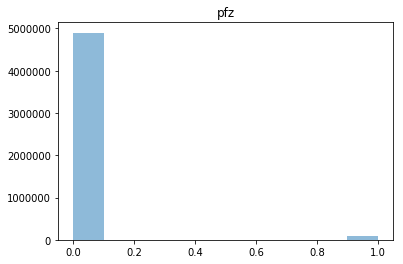

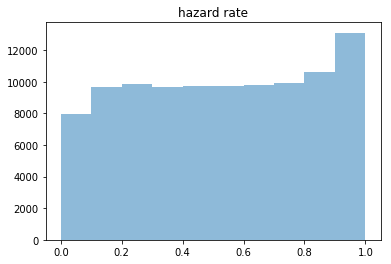

(3.0983785976458256, array([[0.5292428]], dtype=float32), 1.4776795759415986) 0.5276114476508613 0.29095250220180907
probs calced
realisation complete
sns complete


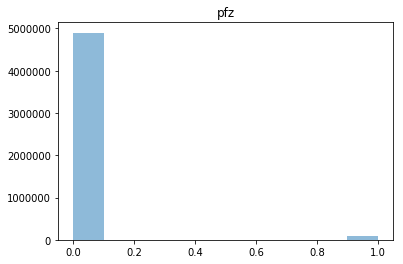

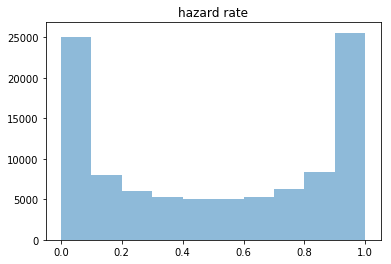

(2.871684769142022, array([[1.8173285]], dtype=float32), 3.593514083602658) 0.5044294375560672 0.3794645697361964
probs calced
realisation complete
sns complete


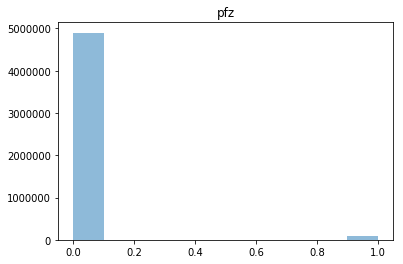

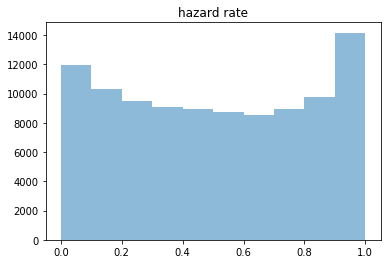

(2.129754450421777, array([[0.7335771]], dtype=float32), 1.906877954445863) 0.5067239330222124 0.30892858284661423
probs calced
realisation complete
sns complete


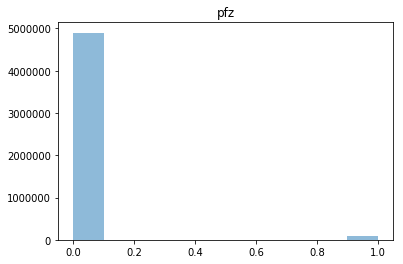

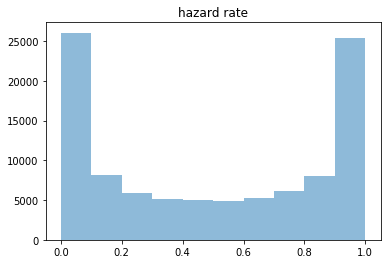

(0.7851517505398493, array([[1.7999961]], dtype=float32), 3.7784418040858108) 0.4969612316921066 0.38171927597308963
probs calced
realisation complete
sns complete


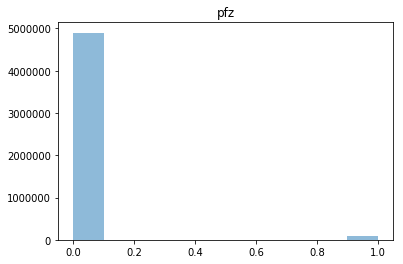

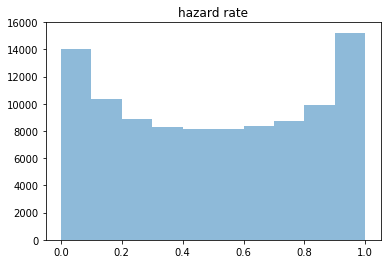

(3.2741480494779687, array([[0.84239584]], dtype=float32), 1.9788103485211517) 0.5041127220101808 0.31906920558444113
probs calced
realisation complete
sns complete


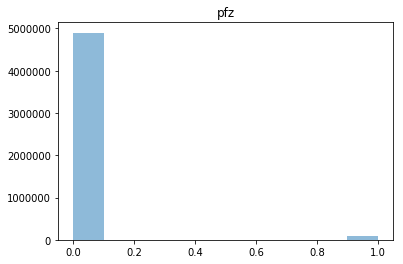

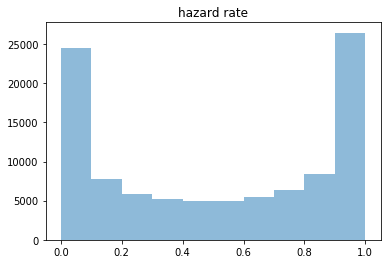

(1.1974066857300105, array([[1.8927248]], dtype=float32), 3.7367792700804077) 0.5133477031983189 0.3800636348037045
probs calced
realisation complete
sns complete


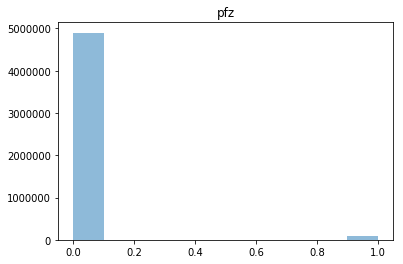

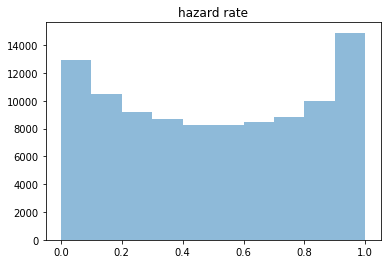

(1.1697408508280258, array([[0.8175145]], dtype=float32), 2.1137693547734866) 0.5063633212275549 0.3153189819710731
probs calced
realisation complete
sns complete


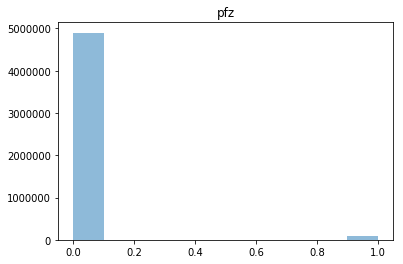

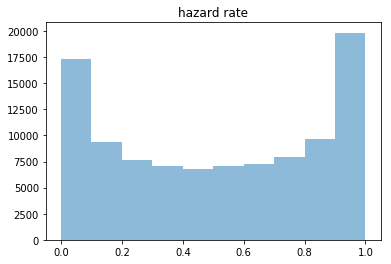

(1.441220172114034, array([[1.1148124]], dtype=float32), 2.5726684404053564) 0.5140372406441527 0.3417271222425223
probs calced
realisation complete
sns complete


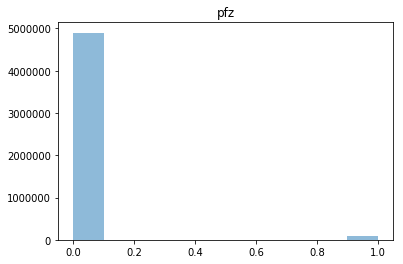

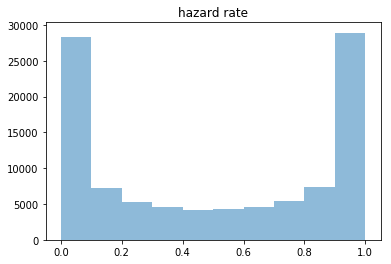

(1.964626843971024, array([[2.3513088]], dtype=float32), 4.389341087214541) 0.5038506519339243 0.39648369111016296
probs calced
realisation complete
sns complete


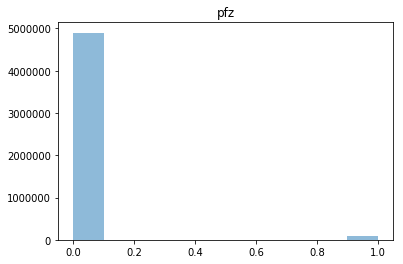

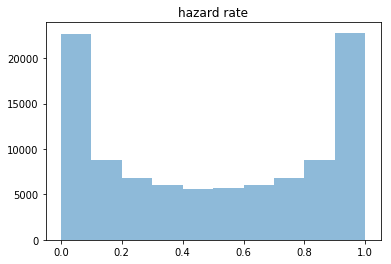

(0.8520382511201459, array([[1.5204682]], dtype=float32), 3.2412680799018885) 0.5012855425350798 0.3658537576221749


In [66]:
for dataset_num in range(n_runs):
    (tw,a0,a1, ss, qs) = pickle.load(open("./synth_data/MLTM_10000_1000_(100_1_5)_{}.p".format(dataset_num), "rb"))
    tr_pairs = get_pairs(ss, qs)
    check_balance_ixs = numpy.random.choice(range(len(tr_pairs)), size=100000)
    pairs_for_check_balance = numpy.array(tr_pairs)[check_balance_ixs,:]
    pfz, sz, qz, _ = stitch_n_split(pairs_for_check_balance, ss, qs, realise=True, rpt=True)

    probs=[]
    for si,qi in pairs_for_check_balance:
        probs.append(calc_probs(ss[si].reshape(1,-1), qs[qi].reshape(1,-1) ))
        
    plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
    plt.title("pfz")
    plt.show()

    plt.hist(numpy.array(probs).flatten(), alpha=0.5)
    plt.title("hazard rate")
    plt.show()

    mn = numpy.mean(probs)
    std = numpy.std(probs)
    print((tw,a0,a1), mn, std)